In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [12]:
file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
#file_path = '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp'
diagType = 'ocean_cobalt_btm'

# yearmons = ['047601-048012', '048101-048512', '048601-049012', '049101-049512', '049601-050012']
yearmons = ['052101-052512','052601-053012']
years = ['0521-0525','0526-0530']

In [15]:
plot_out='../plots_esm42/052422/esm42_prev_'
#plot_out='../plots_esm42/060922/esm42_dev_060922_'

In [16]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'

annual_file_prefix = os.path.join(file_path, diagType, 'av', 'annual_5yr/')
annual_files = [dot.join([annual_file_prefix + diagType, yy, 'ann', 'nc']) for yy in years]
print(annual_files)

['/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_btm/av/annual_5yr/ocean_cobalt_btm.0521-0525.ann.nc', '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_btm/av/annual_5yr/ocean_cobalt_btm.0526-0530.ann.nc']


In [17]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

In [18]:
ds = xr.open_mfdataset(annual_files, combine='by_coords')

In [19]:
# create annual mean
ds = ds.mean(dim='time')

In [20]:
fndet_burial = ds.fndet_burial * 14.0 * 86400 * 365 # g m-2 y-1
fpdet_burial = ds.fpdet_burial * 30.97 * 86400 * 365 # g m-2 y-1

# Compute totals

In [21]:
tot_n_burial = (fndet_burial * grid.areacello).sum().values / 1e12
tot_p_burial = (fpdet_burial * grid.areacello).sum().values / 1e12

In [22]:
tot_p_burial

3.0210090754550065

# Plot

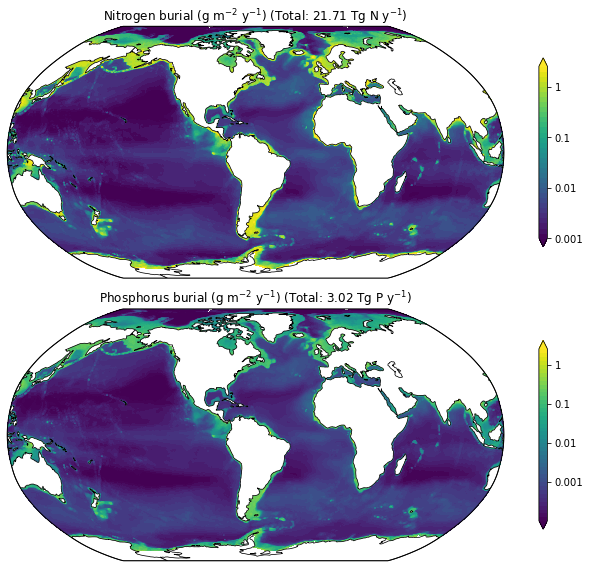

In [23]:
fig=plt.figure(figsize=(10,8))
gs=gridspec.GridSpec(2,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# N Burial                                                                #
###########################################################################
cmin = -3; cmax = 0.5; cint = 0.1
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(fndet_burial)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Nitrogen burial (g m$^{-2}$ y$^{-1}$) (Total: '+str(np.round(tot_n_burial,2))+' Tg N y$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-3,-2,-1,0], shrink=0.75)
cbar.ax.set_yticklabels(['0.001','0.01','0.1','1'])

###########################################################################
# P Burial                                                                #
###########################################################################
cmin = -4; cmax = 0.5; cint = 0.1
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(fpdet_burial)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Phosphorus burial (g m$^{-2}$ y$^{-1}$) (Total: '+str(np.round(tot_p_burial,2))+' Tg P y$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-3,-2,-1,0], shrink=0.75)
cbar.ax.set_yticklabels(['0.001','0.01','0.1','1'])

plt.tight_layout()
fname = 'N_P_burial'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')